<a href="https://colab.research.google.com/github/jafetimbre/ms-school-stuff/blob/master/image-processing/coin_counter/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coin detection and recognition using OpenCV-python

In [1]:
!pip uninstall -y -q opencv-python opencv-contrib-python
!pip install -q opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 30.6 MB 26 kB/s 


In [2]:
import cv2
import numpy as np
from urllib.request import urlopen
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from matplotlib import cm    
import random

We have 3 reference images to start with, each representing a Romanian coin: 


*   **5bani** or 5 Bani, having a value of 0.05 RON
*   **10bani** or 10 Bani, having a value of 0.10 RON
*   **50bani** or 50 Bani, having a value of 0.50 RON



In [3]:
coin_file_names = [
    "5bani",
    "10bani",
    "50bani",
]

base_coins = {}
for name in coin_file_names:
    url = f"https://raw.githubusercontent.com/jafetimbre/ms-school-stuff/master/image-processing/coin_counter/res/manual/{name}.jpg"
    req = urlopen(url)
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    base_coins[name] = cv2.imdecode(arr, -1)

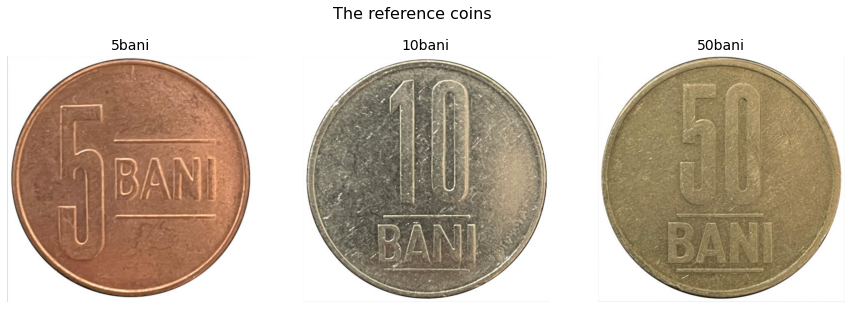

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('The reference coins', fontsize=16)

for i, coin in enumerate(base_coins.items()):
    c_name, c_img = coin
    axs[i].axis("off")
    axs[i].set_title(c_name, fontsize=14)
    axs[i].imshow(cv2.cvtColor(c_img, cv2.COLOR_BGR2RGB))

Applying Canny edge detection on the reference images.

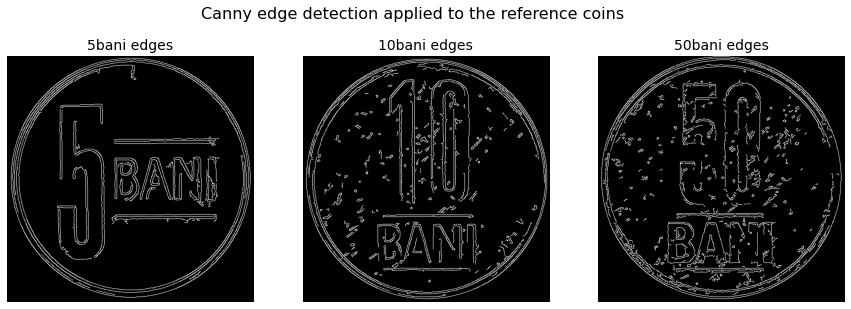

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Canny edge detection applied to the reference coins', fontsize=16)

for i, coin in enumerate(base_coins.items()):
    c_name, c_img = coin

    gray = cv2.cvtColor(c_img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    if c_name == "5bani":
        cny = cv2.Canny(blur, 30, 150)
    elif c_name == "10bani":
        cny = cv2.Canny(blur, 100, 200)
    elif c_name == "50bani":
        cny = cv2.Canny(blur, 50, 100)
    else:
        cny = cv2.Canny(blur, 30, 150)

    axs[i].axis("off")
    axs[i].set_title(f"{c_name} edges", fontsize=14)
    axs[i].imshow(cny, cmap=cm.gray, vmin=0, vmax=255)

For this project we will use the **SIFT (Scale-Invariant Feature Transform)** feature detector and extractor from the opencv-python library.
<br>
<br>
Here is some information about **SIFT**:

*In last couple of chapters, we saw some corner detectors like Harris etc. They are rotation-invariant, which means, even if the image is rotated, we can find the same corners. It is obvious because corners remain corners in rotated image also. But what about scaling? A corner may not be a corner if the image is scaled. For example, check a simple image below. A corner in a small image within a small window is flat when it is zoomed in the same window. So Harris corner is not scale invariant. *

![Tux, the Linux mascot](https://opencv24-python-tutorials.readthedocs.io/en/latest/_images/sift_scale_invariant.jpg)

*So, in 2004, D.Lowe, University of British Columbia, came up with a new algorithm, Scale Invariant Feature Transform (SIFT) in his paper, Distinctive Image Features from Scale-Invariant Keypoints, which extract keypoints and compute its descriptors. ([This paper](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf) is easy to understand and considered to be best material available on SIFT.)*

There are mainly four steps involved in SIFT algorithm:

1.   **Scale-space Extrema Detection**
2.   **Keypoint Localization**
3.   **Orientation Assignment**
4.   **Keypoint Descriptor**

After applying the method we can use **Keypoint Matching** to determine if two share the same features.

For more information please visit this [this link](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html).






In [6]:
nr_features = 5000

sift = cv2.xfeatures2d.SIFT_create(nr_features)
bf = cv2.BFMatcher()

As you can see, we created the SIFT object to scan for `5000` features but for demonstration purposes we will show a maximum of `500` feature points.

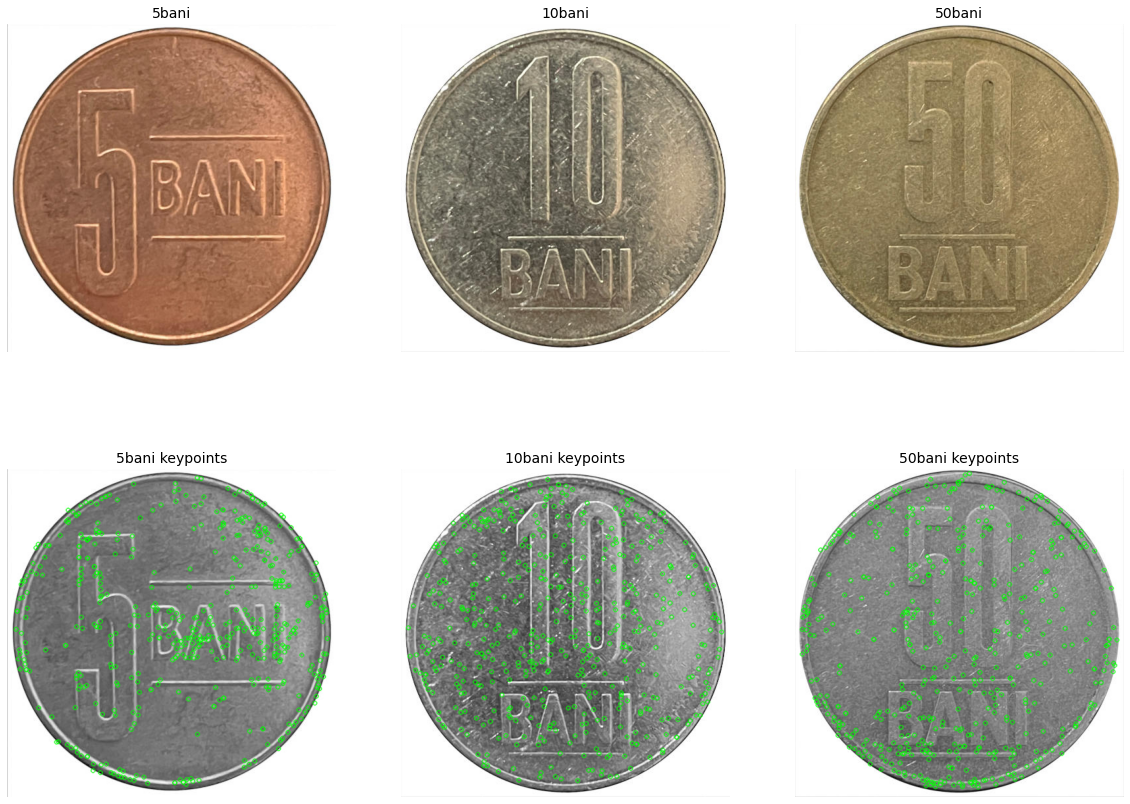

In [7]:
base_refs = {}

fig, axs = plt.subplots(2, 3, figsize=(20,15))
keypoints_to_show = 500

for i, data in enumerate(base_coins.items()):
    name, coin = data
    gray = cv2.cvtColor(coin, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(coin, None)
    base_refs[name] = (keypoints, descriptors)

    axs[0,i].axis("off")
    axs[0,i].set_title(name, fontsize=14)
    axs[0,i].imshow(cv2.cvtColor(base_coins[name], cv2.COLOR_BGR2RGB))

    axs[1,i].axis("off")
    axs[1,i].set_title(f"{name} keypoints", fontsize=14)
    np.random.shuffle(keypoints)
    key_img = cv2.drawKeypoints(gray, keypoints[:keypoints_to_show], None, color=(0,255,0))
    axs[1,i].imshow(cv2.cvtColor(key_img, cv2.COLOR_BGR2RGB))

We applied the **SIFT** detector to identify the features for all three reference coins.

In [8]:
req = urlopen("https://raw.githubusercontent.com/jafetimbre/ms-school-stuff/master/image-processing/coin_counter/res/manual/conis.jpg")
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
coins = cv2.imdecode(arr, -1)

Because we needed to demonstrate the method somehow, we took a photo of some coins laying randomly on a dark surface.

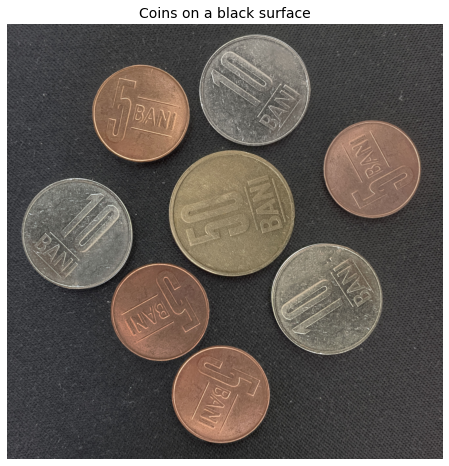

In [9]:
plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Coins on a black surface", fontsize=14)
plt.imshow(cv2.cvtColor(coins, cv2.COLOR_BGR2RGB))

As you can see, there are three types of coins in the image, the ones described in the introduction.
<br>
<br>

In the next step we need to detect each coin separately to do the **Keypoint Matching** with the reference images. For that, we use a series of methods, described below:


1.   RGB to Grayscale color channel transformation
2.   OTSU thresholding
3.   Kernel morphology
4.   Contour finding and cleaning
5.   Computing the area and poly number of each contour
6.   Circle identification
7.   Coin boundary extraction for further analysis





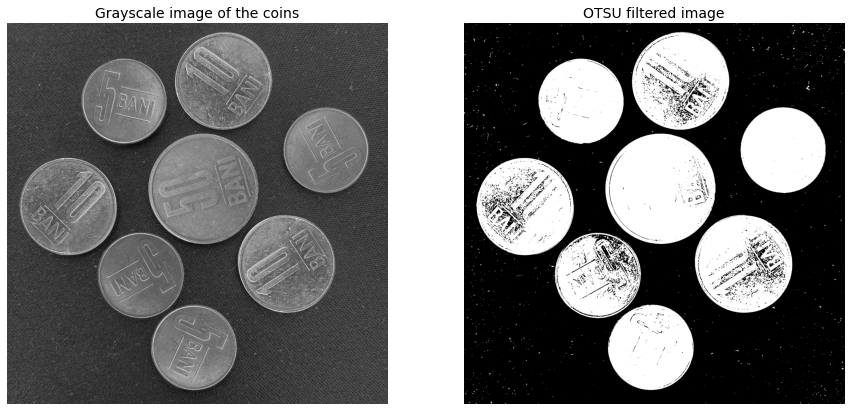

In [10]:
det_coins = coins.copy()
gray = cv2.cvtColor(det_coins, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

fig, axs = plt.subplots(1, 2, figsize=(15,8))
for i, im in enumerate([gray, thresh]):
    axs[i].axis("off")
    axs[i].set_title("Grayscale image of the coins" if i == 0 else "OTSU filtered image", fontsize=14)
    axs[i].imshow(im, cmap=cm.gray, vmin=0, vmax=255)

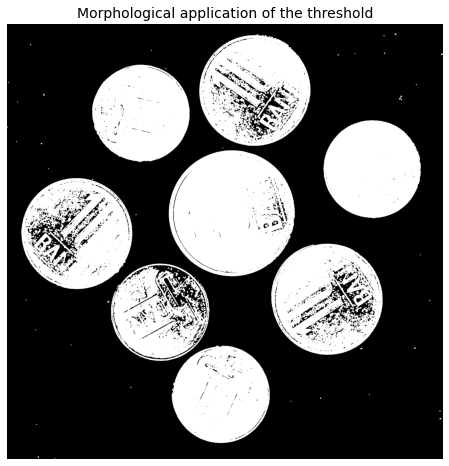

In [11]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Morphological application of the threshold", fontsize=14)
plt.imshow(opening, cmap=cm.gray, vmin=0, vmax=255)

In [12]:
_, contour, hierarchy = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

We apply the `findContours` method from cv2 for finding the contours of the coins.

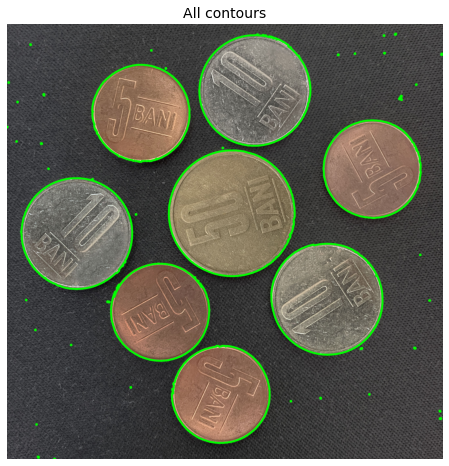

In [13]:
im_c_all = det_coins.copy()
cv2.drawContours(image=im_c_all, contours=contour, contourIdx=-1, color=(0, 255, 0), thickness=10, lineType=cv2.LINE_AA)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("All contours", fontsize=14)
plt.imshow(cv2.cvtColor(im_c_all, cv2.COLOR_BGR2RGB))

After that, we compute the best ones by comparing the area and the poly count of each contour and we add them to the list `coins_contours`

In [14]:
coins_contours = []

for cnt in contour:
    area = cv2.contourArea(cnt)
    if area > 100:
        approx_poly = cv2.approxPolyDP(cnt, .03 * cv2.arcLength(cnt, True), True)
        is_convex = cv2.isContourConvex(approx_poly)
        if is_convex:
            coins_contours.append(cnt)

This is how the result looks like after we removed the false contours:

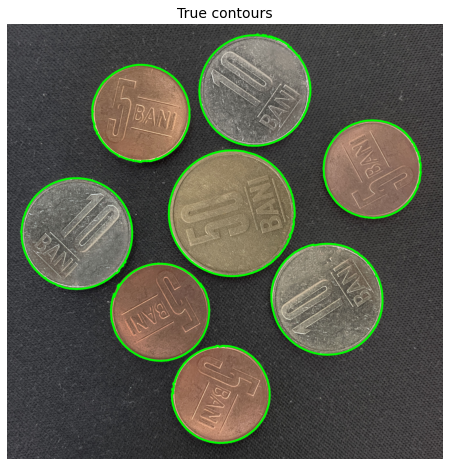

In [15]:
im_c_best = det_coins.copy()
cv2.drawContours(image=im_c_best, contours=coins_contours, contourIdx=-1, color=(0, 255, 0), thickness=10, lineType=cv2.LINE_AA)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("True contours", fontsize=14)
plt.imshow(cv2.cvtColor(im_c_best, cv2.COLOR_BGR2RGB))

For visualizing the process, we described each step with an image.


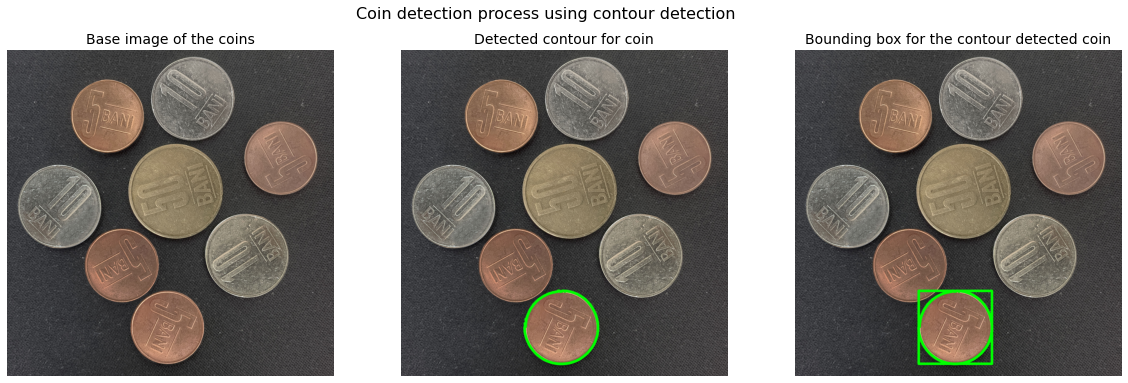

In [16]:
im_c = det_coins.copy()
cnt = coins_contours[0]

cv2.drawContours(image=im_c, contours=[cnt], contourIdx=-1, color=(0, 255, 0), thickness=20, lineType=cv2.LINE_AA)
im_r = im_c.copy()
approx_poly = cv2.approxPolyDP(cnt, .03 * cv2.arcLength(cnt, True), True)
x, y, w, h = cv2.boundingRect(approx_poly)
cv2.rectangle(im_r, (x, y), (x+w, y+h), (0, 255, 0), 20)

fig, axs = plt.subplots(1, 3, figsize=(20,6))
fig.suptitle("Coin detection process using contour detection", fontsize=16)
titles = [ "Base image of the coins", "Detected contour for coin", "Bounding box for the contour detected coin"]
for i, im in enumerate([det_coins, im_c, im_r]):
    axs[i].axis("off")
    axs[i].set_title(titles[i], fontsize=14)
    axs[i].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In this step we get the poly count of the contours and we compute the bounding box of each coin for better separation.

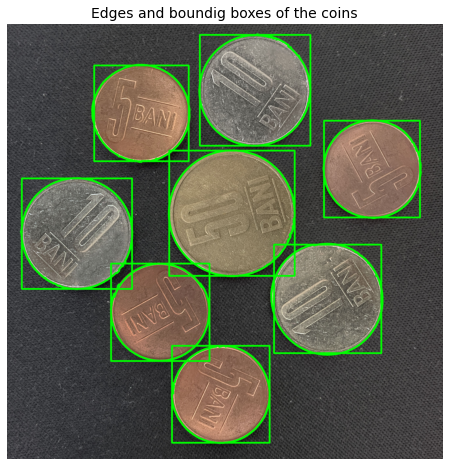

In [17]:
coins_roi = []

for cnt in coins_contours:
    cv2.drawContours(image=det_coins, contours=[cnt], contourIdx=-1, color=(0, 255, 0), thickness=10, lineType=cv2.LINE_AA)
    approx_poly = cv2.approxPolyDP(cnt, .03 * cv2.arcLength(cnt, True), True)
    x, y, w, h = cv2.boundingRect(approx_poly)
    cv2.rectangle(det_coins, (x, y), (x+w, y+h), (0, 255, 0), 10)
    coins_roi.append((x, y, w, h))

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Edges and boundig boxes of the coins", fontsize=14)
plt.imshow(cv2.cvtColor(det_coins, cv2.COLOR_BGR2RGB))

After this step we can separate each coin from the base image into individual images. This is what the result looks like:

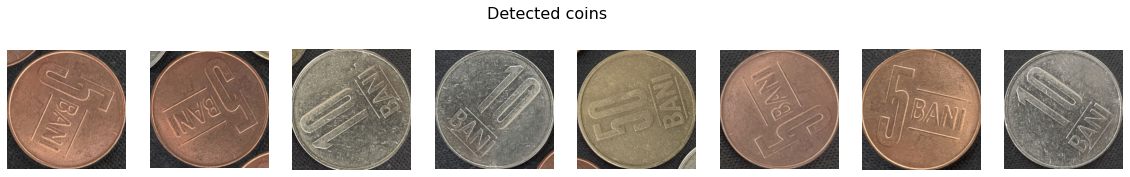

In [18]:
nr_coins = len(coins_roi)
fig, axs = plt.subplots(1, nr_coins, figsize=(20,3))
fig.suptitle('Detected coins', fontsize=16)

for i, roi in enumerate(coins_roi):
    axs[i].axis("off")
    coin = coins[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
    axs[i].imshow(cv2.cvtColor(coin, cv2.COLOR_BGR2RGB))

Next, we apply the **SIFT** method for  each detected coin and as a result we will get pairs of keypoints and descriptors, used for the feature matching step. For demonstration purposes we will run the process on the first detected coin in more detail.

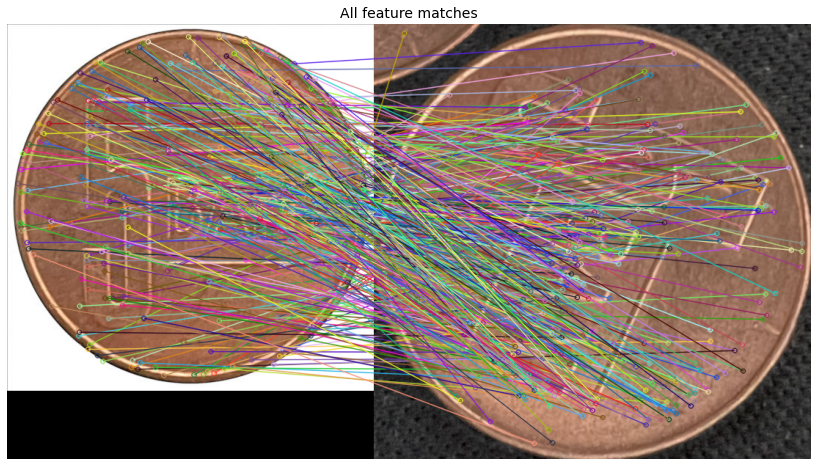

In [19]:
k1, d1 = base_refs["5bani"]

roi = coins_roi[0]
coin = coins[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]

gray = cv2.cvtColor(coin, cv2.COLOR_BGR2GRAY)

k2, d2 = sift.detectAndCompute(gray, None)

matches = bf.knnMatch(d1, d2, k=2)

good_matches = []
for m1, m2 in matches:
    if m1.distance < 0.6 * m2.distance:
        good_matches.append([m1])

SIFT_matches_all = cv2.drawMatchesKnn(base_coins["5bani"], k1, coin, k2, good_matches, None, flags=2)

plt.figure(figsize = (16, 8))
plt.axis("off")
plt.title("All feature matches", fontsize=14)
plt.imshow(cv2.cvtColor(SIFT_matches_all, cv2.COLOR_BGR2RGB))

We will repeat the process for the first detected coin and all the reference coins.

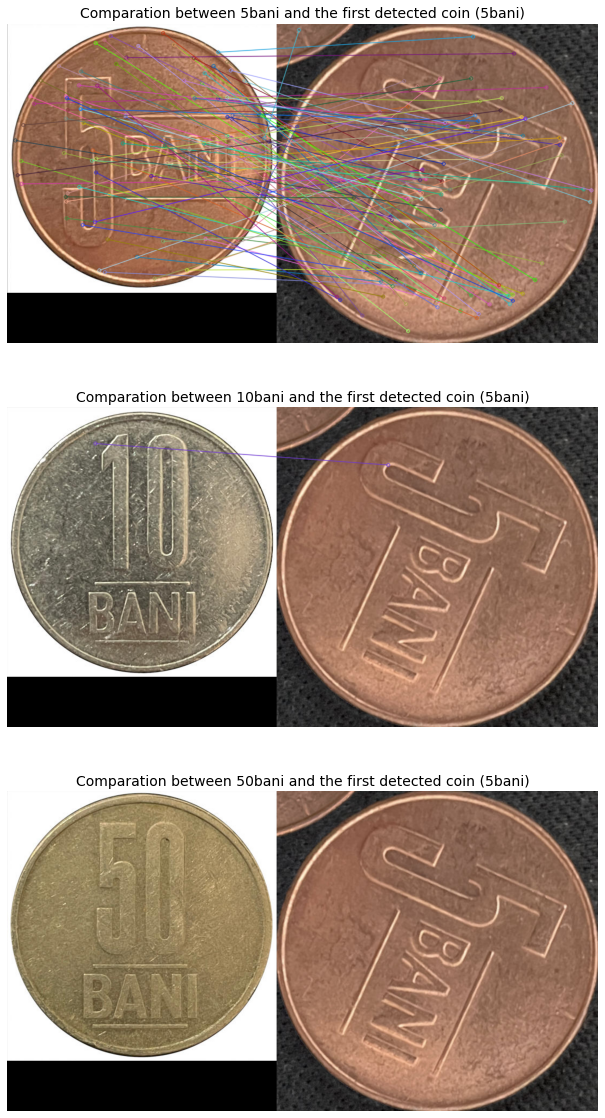

In [20]:
roi = coins_roi[0]
coin = coins[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]

gray = cv2.cvtColor(coin, cv2.COLOR_BGR2GRAY)
k2, d2 = sift.detectAndCompute(gray, None)

matches_to_show = 100
fig, axs = plt.subplots(3, 1, figsize=(18, 20))

for i, data in enumerate(base_refs.items()):
    name, (k1, d1) = data

    matches = bf.knnMatch(d1, d2, k=2)
    good_matches = []
    for m1, m2 in matches:
        if m1.distance < 0.6 * m2.distance:
            good_matches.append([m1])
    
    np.random.shuffle(good_matches)
    SIFT_matches_some = cv2.drawMatchesKnn(base_coins[name], k1, coin, k2, good_matches[:matches_to_show], None, flags=2)

    x = int(np.floor(i / 2))
    y = i % 2
    axs[i].axis("off")
    axs[i].set_title(f"Comparation between {name} and the first detected coin (5bani)", fontsize=14)
    axs[i].imshow(cv2.cvtColor(SIFT_matches_some, cv2.COLOR_BGR2RGB))   

We assign each detected coin with a desired value that represents the true value of the coin.

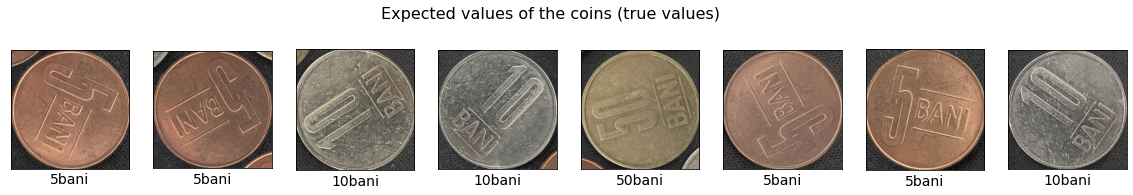

In [21]:
nr_coins = len(coins_roi)
fig, axs = plt.subplots(1, nr_coins, figsize=(20,3))
fig.suptitle('Expected values of the coins (true values)', fontsize=16)
expected = ['5bani', '5bani', '10bani', '10bani', '50bani', '5bani', '5bani', '10bani']

for i, roi in enumerate(coins_roi):
    axs[i].get_yaxis().set_ticks([])
    axs[i].get_xaxis().set_ticks([])
    axs[i].set_xlabel(expected[i], fontsize=14)
    coin = coins[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
    axs[i].imshow(cv2.cvtColor(coin, cv2.COLOR_BGR2RGB))

Furthermore, with the help of Keypoint Matching, we can assign each detected coin a label from the following: `[ 5bani, 10bani, 50bani ]`

In [22]:
results = []
for roi in coins_roi:
    coin = coins[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
    gray = cv2.cvtColor(coin, cv2.COLOR_BGR2GRAY)
    k2, d2 = sift.detectAndCompute(gray, None)
    res = {}
    for data in base_refs.items():
        name, (k1, d1) = data
        matches = bf.knnMatch(d1, d2, k=2)
        good_matches = []
        for m1, m2 in matches:
            if m1.distance < 0.6 * m2.distance:
                good_matches.append([m1])
        res[name] = len(good_matches)
    results.append(max(res, key=res.get))

This is what the results look like:

In [23]:
results

['5bani', '5bani', '10bani', '10bani', '50bani', '5bani', '5bani', '10bani']

For a better representation, we will show all the detected coins with their `TRUE VALUE` and `DETECTED VALUE`.

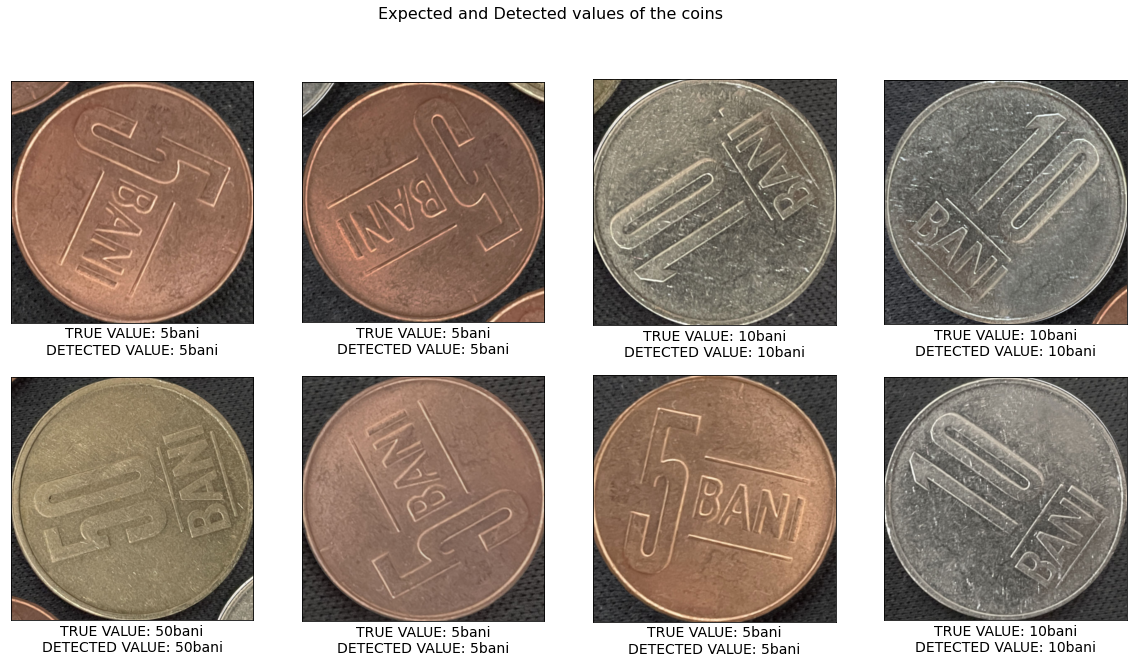

In [24]:
nr_coins = len(coins_roi)
fig, axs = plt.subplots(2, int(nr_coins/2), figsize=(20,10))
fig.suptitle('Expected and Detected values of the coins', fontsize=16)

for i, roi in enumerate(coins_roi):
    x = 0 if i < 4 else 1
    y = i if i < 4 else i - 4

    axs[x,y].get_yaxis().set_ticks([])
    axs[x,y].get_xaxis().set_ticks([])
    coin = coins[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
    axs[x,y].imshow(cv2.cvtColor(coin, cv2.COLOR_BGR2RGB))
    axs[x,y].set_xlabel(f"TRUE VALUE: {expected[i]}\nDETECTED VALUE: {results[i]}", fontsize=14)

Now we can put a label on each coin from the base image

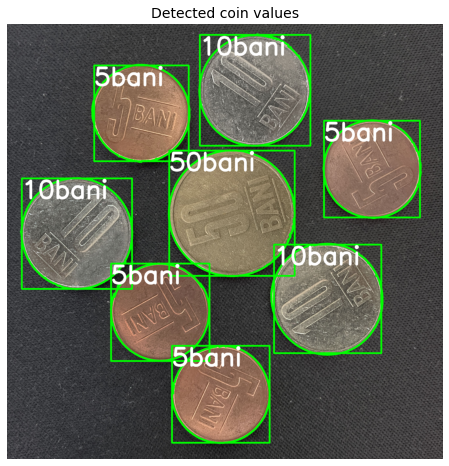

In [25]:
show_detected = det_coins.copy()

for i, roi in enumerate(coins_roi):
    cv2.putText(show_detected, results[i], (roi[0], roi[1]+120), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 255, 255), 15)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Detected coin values", fontsize=14)
plt.imshow(cv2.cvtColor(show_detected, cv2.COLOR_BGR2RGB))

As for the result, we can compute a total value of the coins:


> We have `100 bani` or `1 lei` in romanian currency.




In [26]:
values = [int(val.replace("bani", "")) for val in results]
coin_values_sum = np.sum(values)

print(f"You have {coin_values_sum} bani or {coin_values_sum/100} lei.")

You have 100 bani or 1.0 lei.
